In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')
sys.path.append('/usr/users/fsimone/tejaas')
import numpy as np
import scipy.stats as ss
import random
import os
import pandas as pd
from iotools.readRPKM import ReadRPKM
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA

def knn_correction(expr, K, f=1):
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1])))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    neighbor_list = list()

    neighbour_comp = np.zeros(expr.shape)
    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        neighbour_comp[i,:] = np.mean(expr[neighbors, :], axis = 0)

    return gx_knn, neighbour_comp

In [3]:
import operator
import json
from utils import utils
json_file = "../../gtex_v8_metadata.json"
tissue_file = "../../plots/tissues.txt"
tshorts, tfulls_plain = utils.read_tissues(tissue_file, plain=True)
_, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull
for tshort, tfull in zip(tshorts, tfulls):
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

sorted_tissues = [x[0] for x in sorted(tissue_samples.items(), key=operator.itemgetter(1))]
select_tissues = tshorts


In [3]:
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 100)

def scale_covariates(df_cov):
    # scale covariates
    NAmask = pd.isna(df_cov)
    means = np.mean(df_cov.T)
    stds = np.std(df_cov.T)
    diff = (df_cov.T[~NAmask.T] - means) / stds
    return diff.T

def scale_covariates_nan(df_cov):
    new_df = pd.DataFrame([])
    for r in df_cov.index:
        NAmask = pd.isna(df_cov.loc[r])
        means = np.mean(df_cov.loc[r].T)
        stds = np.std(df_cov.loc[r].T)
        diff = pd.DataFrame((df_cov.loc[r][~NAmask] - means) / stds )
        new_df = pd.concat([new_df, diff.T],sort=False)
        # Nan values will be added as other sample names are introduced and gaps will be filled with Nans
    return new_df

In [29]:
## Subject Covariates from GTEx_v8 as in "The impact of rare variation on gene expression across tissues"
subj_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/phs000424.v8.pht002742.v8.p2.c1.GTEx_Subject_Phenotypes.GRU.txt"
subj_df = pd.read_csv(subj_file, comment="#", sep="\t", header=0)

cov_dict = dict()
cov_dict["TRDNISCH"]  = "Total Ischemic time for a donor"
cov_dict["TRISCHD"]   = "Ischemic Time (Minutes)"
cov_dict['DTHRFG']    = "Body Refrigerated"
cov_dict['MHSRC']     = 'Primaty History Source'
cov_dict["LBPRRVDRL"] = "PRR VDRL Serology"
cov_dict["LBHBCABM"]  = "HBcAb IgM Serology"
cov_dict["DTHATPSY"]  = "Autopsy performed By Coroner or ME"
cov_dict['AGE']       = "Age"
cov_dict['RACE']      = "Race"
cov_dict['MHABNWBC']  = "Abnormal WBC"
cov_dict["TRCRTMP"]   = "Core Body Temperature"
cov_dict["SEX"]       = "Sex"
cov_dict['DTHVNT']    = "Donor On A Ventilator Immediately Prior To Death"
cov_dict["DTHVNTD"]   = "Time Interval On Ventilator"
cov_dict["TRVNTSR"]   = "On ventilator less than 24 hours"
cov_dict["DTHVNT"]    = "Donor On A Ventilator Immediately Prior To Death"
cov_dict["LBEBVGAB"]  = "EBV IgG Ab"
cov_dict["LBEBVMAB"]  = "EBV IgM Ab"
cov_dict["LBCMVTAB"]  = "CMV Total Ab"
cov_dict['COHORT']    = "Cohort"
cov_dict["TRCHSTIND"] = "Time of Chest Incision (Minutes)"
cov_dict['DTHPLCE']   = "Place of Death"
cov_dict['DTHHRDY']   = "Hardy Scale"

# cov_dict["ETHNCTY"]   = "Ethnicity"
# cov_dict['DTHTYP']    = "Specific cause of death based on ICD-10 coding"
# cov_dict['DTHICD10']  = "ICD-10 Code for cause of death"
# cov_dict['DTHCLS']    = "Classification of death based on ICD-10 coding"
# cov_dict['DTHCAT']    = "Category of death based on ICD-10 coding"
# cov_dict['DTHCOD']    = "Immediate Cause Of Death"
# cov_dict['DTHFUCOD']  = "First Underlying Cause Of Death"
# cov_dict['DTHCERT']   = "Death Certificate Available"
# cov_dict['MHASCITES'] = "Ascites"
# cov_dict['DTHLUCOD']  = "Last Underlying Cause Of Death"
# cov_dict['TRISCH']    = "Ischemic Time"
# cov_dict['TRCRTMPL']  = "Core Body Temperature - Location of measurment"
# cov_dict["TRCHSTIN"]  = "Time of Chest Incision"
# cov_dict["DTHVNTDU"]  = "Time Interval On Ventilator Unit"

subj_covariates= list(cov_dict.keys()) 
select_columns = ["SUBJID"] + subj_covariates
SUBJ_DF = subj_df[select_columns]

In [30]:
## Sample Covariates 
sample_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/phs000424.v8.pht002743.v8.p2.c1.GTEx_Sample_Attributes.GRU.txt"
sample_df = pd.read_csv(sample_file, comment="#", sep="\t", header=0)

sample_cov_dict = dict()
sample_cov_dict["SMTRSCPT"] = "Transcripts Detected" #: Total number of transcripts with at least 5 exon mapping reads"
sample_cov_dict["SMGNSDTC"] = "Genes detected"
sample_cov_dict["SMSPLTRD"] = "Split Reads"
sample_cov_dict["SMCENTER"] = "Code for BSS collection site"
sample_cov_dict["SMATSSCR"] = "Autolysis Score"
sample_cov_dict["SME2PCTS"] = "End 2 % Sense" # : Percentage of intragenic End 2 reads that were sequenced in the sense direction"
sample_cov_dict["SME1SNSE"] = "End 1 Sense" # : Number of End 1 reads that were sequenced in the sense direction"
sample_cov_dict["SME2SNSE"] = "End 2 Sense" # : Number of End 2 reads that were sequenced in the sense direction"
sample_cov_dict["SME2ANTI"] = "End 2 Antisense" # : Number of reads that were sequenced in the antisense direction"
sample_cov_dict["SME1ANTI"] = "End 1 Antisense" # : Number of End 1 reads that were sequenced in the antisense direction"
sample_cov_dict["SME1MPRT"]  = "End 1 Mapping Rate" # : the number of End 1 mapped reads divided by the total number of End 1 reads"
sample_cov_dict["SME2MPRT"]  = "End 2 Mapping Rate" # : the number of End 2 mapped reads divided by the total number of End 1 reads"
sample_cov_dict["SME1MMRT"]  = "End 1 Mismatch Rate" # : The number of End 1 bases not matching the reference divided by the total number of End 1 bases."
sample_cov_dict["SME2MMRT"]  = "End 2 Mismatch Rate" #  The number of End 2 bases not matching the reference divided by the total number of End 2 bases."
sample_cov_dict["SMMPPDUN"]  = "Mapped Unique" # : Number of reads that were aligned and did not have duplicate flags"
sample_cov_dict["SMMPPD"]    = "Mapped" # : Total number of reads aligned/mapped"
sample_cov_dict["SMMPPDPR"]  = "Mapped Pairs" # :Total number of pairs for which both ends map"
sample_cov_dict["SMRDTTL"]   = "Total reads" #  (filtered to exclude reads with vendor fail or alternative alignment flags)"
sample_cov_dict["SMMFLGTH"]  = "Fragment Length Mean"
sample_cov_dict["SMSFLGTH"]  = "Fragment Length StdDev" # : The fragment length is the distance between the start of an upstream read and the end of the downstream pair mate"
sample_cov_dict["SMALTALG"]  = "Alternative Aligments" # : duplicate read entries providing alternative coordinates"
sample_cov_dict["SMNTERRT"]  = "Intergenic Rate" # : The fraction of reads that map to the genomic space between genes"
sample_cov_dict["SMNTRART"]  = "Intragenic Rate" # : The fraction of reads that map within genes (within introns or exons)"
sample_cov_dict["SMRRNART"]  = "RRNA Rate" # : Ratio of all reads aligned to rRNA regions to total reads"
sample_cov_dict["SMRRNANM"]  = "RRNA: Number of all reads" #  (duplicate and non-duplicate) aligning to ribosomal RNA regions"
sample_cov_dict["SMTSISCH"]  = "Total Ischemic time for a sample"
sample_cov_dict["SMRIN"]     = "RIN Number"
sample_cov_dict["SMNTRNRT"]  = "Intronic Rate" # : The fraction of reads that map within introns"
sample_cov_dict["SMEXNCRT"]  = "Exonic Rate" # : The fraction of reads that map within exons"
sample_cov_dict["SMEXPEFF"]  = "Expression Profiling Efficiency" # : Ratio of exon reads to total reads"
sample_cov_dict["SMGEBTCHD"] = "Date of genotype or expression batch"
sample_cov_dict["SMNABTCHT"] = "Type of nucleic acid isolation batch"
sample_cov_dict["SMGEBTCH"]  = "Genotype or Expression Batch ID"
sample_cov_dict["SMNABTCHD"] = "Date of nucleic acid isolation batch"
sample_cov_dict["SMNABTCH"]  = "Nucleic Acid Isolation Batch ID"

sample_cov_dict["SME1PCTS"] = "End 1 % Sense" # : Percentage of intragenic End 1 reads that were sequenced in the sense direction"
sample_cov_dict["SMMAPRT"]  = "Mapping Rate" # : Ratio of total mapped reads to total reads"
sample_cov_dict["SMUNMPRT"] = "Unique Rate of Mapped" # : Unique reads divided by all mapped reads."
sample_cov_dict["SMMPUNRT"] = "Mapped Unique Rate of Total" # : Ratio of mapping of reads that were aligned and were not duplicates to total reads"
sample_cov_dict["SMESTLBS"] = "Estimated library size" # : Number of expected fragments based on the total reads and duplication rate assuming a Poisson distribution."

sample_cov_dict["SMTSD"]    = "Tissue Type"

sample_covariates= list(sample_cov_dict.keys()) 
select_columns = ["SAMPID"] + sample_covariates
# Make sure to select TruSeq RNA-seq experiments!! in SMGEBTCHT
# Remove FLAGGED samples! duh!
SAMPLE_DF = sample_df[sample_df["SMGEBTCHT"].str.match("TruSeq") & ~sample_df["SMTORMVE"].str.match("FLAGGED").fillna(False) ][select_columns]

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Factorize categories in both covariate sets
* Dates are just converted to consecutive number (but without any date ordering)

In [31]:
# Check Subject covariates
# Covariates with more than one category, which one to binarize?
for c,t in zip(subj_covariates, SUBJ_DF[subj_covariates].dtypes):
    if t == "object":
        #print(c, set(SUBJ_DF[c]),t)
        values, categories = SUBJ_DF[c].factorize()
        if len(categories) > 1:
            print(c, len(categories))
    else:
        pass
        #print(c, set(SUBJ_DF[c]))

MHSRC 2
COHORT 3
DTHPLCE 15


In [32]:
# Check Sample covariates
# Covariates with more than one category, which one to binarize?
for c,t in zip(sample_covariates, SAMPLE_DF[sample_covariates].dtypes):
    if t == "object":
        #print(c, set(SUBJ_DF[c]),t)
        values, categories = SAMPLE_DF[c].factorize()
        if len(categories) > 1:
            print(c, len(categories))
    else:
        pass
        # print(c, set(SAMPLE_DF[c][:100]))

SMCENTER 7
SMGEBTCHD 227
SMNABTCHT 4
SMGEBTCH 406
SMNABTCHD 709
SMNABTCH 1258
SMTSD 54


In [33]:
# Binarize any thing with more than 4 categories
# Also, take car of covariates encoded in numbers, delete those '98' or '99' that just mean 'unknown'
for c,t in zip(subj_covariates, SUBJ_DF[subj_covariates].dtypes):
    if t == "object":
        # print(c, set(SUBJ_DF[c]),t)
        values, categories = SUBJ_DF[c].factorize()
        if len(categories) > 1 and len(categories) <= 4:
            # Split each category into a new binary columns
            for x in range(len(categories)):
                new_cat_name = c+"_{:d}".format(x)
                cov_dict[new_cat_name] = f"{cov_dict[c]} - {categories[x]}"
                # print(new_cat_name, categories[x])
                new_values = np.zeros(values.shape)
                new_values[values == x ] = 1
                new_values[values == -1] = np.nan
                SUBJ_DF[new_cat_name] = new_values    
            SUBJ_DF.drop(c, axis=1, inplace=True)
        else:
            # Already binarizable, easy!
            SUBJ_DF.loc[:,c] = values
            SUBJ_DF[c].replace({-1:np.nan}, inplace=True)
    elif c in ["RACE","DTHRFG","LBPRRVDRL","LBHBCABM","DTHVNT","LBEBVGAB","LBEBVMAB","LBCMVTAB"]:
        SUBJ_DF.loc[ SUBJ_DF[c] > 4, c ] = np.nan

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

In [34]:
for c,t in zip(sample_covariates, SAMPLE_DF[sample_covariates].dtypes):
    if t == "object":
        # print(c, set(SAMPLE_DF[c]),t)
        if c == "SMTSD": # Don't do for tissue type
            continue
        values, categories = SAMPLE_DF[c].factorize()
        # if it has more than 4 categories, just leave it as is and assign numbers
        if len(categories) > 1 and len(categories) <= 4:
            # Split each category into a new binary columns
            for x in range(len(categories)):
                new_cat_name = c+"_{:d}".format(x)
                sample_cov_dict[new_cat_name] = f"{sample_cov_dict[c]} - {categories[x]}"
                # print(new_cat_name, categories[x])
                new_values = np.zeros(values.shape)
                new_values[values == x ] = 1
                new_values[values == -1] = np.nan
                SAMPLE_DF[new_cat_name] = new_values
            SAMPLE_DF.drop(c, axis=1, inplace=True)
        else:
            # Already binarizable, easy!
            SAMPLE_DF.loc[:,c] = values
            SAMPLE_DF[c].replace({-1:np.nan}, inplace=True)

In [35]:
# # Check for scaling covariates
# new_df = pd.DataFrame([])
# df_cov = TISSUE_COVS[nb_df.columns].copy(deep=True)
# for r in df_cov.index:
#     print(r)
#     NAmask = pd.isna(df_cov.loc[r])
#     means = np.mean(df_cov.loc[r].T)
#     stds = np.std(df_cov.loc[r].T)
#     diff = pd.DataFrame((df_cov.loc[r][~NAmask] - means) / stds )
#     print(new_df.shape)
#     print(diff.T.shape)
#     new_df = pd.concat([new_df, diff.T], sort=True)
#     # Nan values will be added as other sample names are introduced and gaps will be filled with Nans
# new_df

In [40]:
print(SAMPLE_DF[["SMTSD","SMTSISCH"]][SAMPLE_DF.SMTSD.str.contains("Brain")].groupby(["SMTSD"]).min())
SAMPLE_DF[["SMTSD","SMTSISCH"]][SAMPLE_DF.SMTSD.str.contains("Brain")].groupby(["SMTSD"]).max()

                                           SMTSISCH
SMTSD                                              
Brain - Amygdala                              223.0
Brain - Anterior cingulate cortex (BA24)      223.0
Brain - Caudate (basal ganglia)               223.0
Brain - Cerebellar Hemisphere                 223.0
Brain - Cerebellum                            380.0
Brain - Cortex                                379.0
Brain - Frontal Cortex (BA9)                  223.0
Brain - Hippocampus                           223.0
Brain - Hypothalamus                          223.0
Brain - Nucleus accumbens (basal ganglia)     223.0
Brain - Putamen (basal ganglia)               323.0
Brain - Spinal cord (cervical c-1)            322.0
Brain - Substantia nigra                      223.0


SMTSISCH
SMTSD                                              
Brain - Amygdala                             1375.0
Brain - Anterior cingulate cortex (BA24)     1407.0
Brain - Caudate (basal ganglia)              1407.0
Brain - Cerebellar Hemisphere                1407.0
Brain - Cerebellum                           1669.0
Brain - Cortex                               1668.0
Brain - Frontal Cortex (BA9)                 1350.0
Brain - Hippocampus                          1360.0
Brain - Hypothalamus                         1360.0
Brain - Nucleus accumbens (basal ganglia)    1375.0
Brain - Putamen (basal ganglia)              1375.0
Brain - Spinal cord (cervical c-1)           1375.0
Brain - Substantia nigra                     1375.0

# Variance from subject and sample phenotypes captured by KNN

First, it makes a simple linear regression of each covariate against the KNN component.
Then, it makes a multiple linear regression of the KNN component against:
- All covariates
- Covariates with r2>0.05
- Lasso regression of all covariates

In [10]:
knn_cov_r2 = pd.DataFrame([])
multi_r2   = list()
multi_r2_c = list()
R2_CUTOFF = 0.05

multi_r2_lasso = list()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull

for tissue in tshorts:
    if tissue not in select_tissues:
        continue
    print(tissue)
    gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue)
    rpkm = ReadRPKM(gx_file, "gtex")
    expression = rpkm.expression
    expr_donors = rpkm.donor_ids
    gene_names = rpkm.gene_names

    gx_corr, nb_comp = knn_correction(expression.T, 30)
    nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)

    # Covariates have size Covariates (rows) x Nsamples (columns)
    
    # PUBLIC Covariates
    cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
    df_cov_pub = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
    df_cov_pub.drop(["sex", "AGE", "PMI"], inplace=True)
    
    # SUBJECT covariates
    df_cov = SUBJ_DF.T.copy(deep=True)
    df_cov.columns = df_cov.loc["SUBJID"]
    df_cov.drop(["SUBJID"], inplace=True)
    
    # SAMPLE covariates
    TISSUE_SAMPLE_DF = SAMPLE_DF[ SAMPLE_DF["SMTSD"] == tissue_names[tissue] ].T.copy(deep=True)
    new_columns = ["-".join(i.split("-")[:2]) for i in TISSUE_SAMPLE_DF.loc["SAMPID"].values]
    TISSUE_SAMPLE_DF.columns = new_columns
    TISSUE_SAMPLE_DF.drop("SAMPID", inplace=True)

    ALL_COVS = pd.concat([df_cov_pub, df_cov, TISSUE_SAMPLE_DF], join='inner')
    TISSUE_COVS = ALL_COVS.loc[~(ALL_COVS.nunique(axis=1) == 1),:]
    
    sort_cov_df = scale_covariates_nan(TISSUE_COVS[nb_df.columns])
    
    # Multiple Linear regression of each covariate against KNN component of expression
    r2_list = list()
    covname_list   = list()
    K = 30
    
    # Iterate through covariates one by one
    for i in range(sort_cov_df.shape[0]):
        reg = linear_model.LinearRegression()
        nan_mask = pd.isna(sort_cov_df.iloc[i,:].values)
        observations_left = sort_cov_df.shape[1] - np.sum(nan_mask)
        if observations_left > 50:
            X = sort_cov_df.iloc[i,:].values[~nan_mask][:,np.newaxis]
            Y = nb_df.iloc[:,~nan_mask].T 

            reg.fit(X, Y)
            r2 = reg.score(X, Y)
            r2_list.append(r2)
            covname_list.append(sort_cov_df.index[i])
            print(sort_cov_df.index[i], r2)
        else:
            print(sort_cov_df.index[i], "Not enough obs ({:d})".format(observations_left))
    
    tissue_r2_df = pd.DataFrame(np.array(r2_list), index=covname_list, columns = [tissue])
    knn_cov_r2 = pd.concat([knn_cov_r2, tissue_r2_df], axis=1, sort=True)
    
    gx_corr, nb_comp = knn_correction(expression.T, K)
    nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
    reg = linear_model.LinearRegression()
    X = sort_cov_df.loc[covname_list].T ## (12, 581,)
    Y = nb_df.T 
    reg.fit(X.fillna(0), Y)
    r2 = reg.score(X.fillna(0), Y)
    multi_r2.append((tissue, r2))
    print("R^2 : {:g}".format(r2))
    
    covname_list_c = knn_cov_r2[ knn_cov_r2[tissue] > R2_CUTOFF ].index
    X = sort_cov_df.loc[covname_list_c].T 
    Y = nb_df.T 
    reg.fit(X.fillna(0), Y)
    r2 = reg.score(X.fillna(0), Y)
    multi_r2_c.append((tissue, r2))
    print("R^2 w CUTOFF: {:g}".format(r2))
    
#     print("Start lasso") ### Never finishes... too long to wait
#     # Lasso Multiple Linear regression
#     reg = linear_model.MultiTaskLassoCV(cv=5)
#     X = sort_cov_df.T
#     Y = nb_df.T 
#     reg.fit(X.fillna(0), Y)
#     r2 = reg.score(X.fillna(0), Y)
#     multi_r2_lasso.append((tissue, r2))
#     print("R^2 lasso: {:g}".format(r2))
    

as
PC1 0.2742298027040134
PC2 0.0025603278142619142
PC3 0.0012485631561980112
PC4 0.0024077926677780817
PC5 0.0033871718657323725
pcr 0.001498854372311051
platform 0.002806890236232645
TRDNISCH 0.07294856156221834
TRISCHD 0.07469910653358183
DTHRFG 0.06696700351437093
LBHBCABM 0.0037986574043600055
DTHATPSY 0.02390866834513347
AGE 0.025801222691320777
RACE 0.17078353660641504
MHABNWBC 0.0006343799113085637
TRCRTMP 0.01708793616586735
SEX 0.005757518165565323
DTHVNT 0.0796073170113349
DTHVNTD 0.008081170601828832
LBEBVGAB 0.006822255546346312
LBEBVMAB 0.001966220544543803
LBCMVTAB 0.024454822711156027
TRCHSTIND 0.08635129865982444
DTHPLCE 0.03548118826713709
DTHHRDY 0.060572875088328516
MHSRC_0 0.0134808284363035
MHSRC_1 0.013480828436303499
COHORT_0 0.08151176324901045
COHORT_1 0.08260397052034155
COHORT_2 0.038971628940670966
SMTRSCPT 0.035390720189310186
SMGNSDTC 0.03530918606565422
SMSPLTRD 0.002563544677236546
SMCENTER 0.021667946369811987
SMATSSCR 0.005390274032731363
SME2PCTS 0.0

platform 0.0074340056148466315
TRDNISCH 0.09938721580545634
TRISCHD 0.10248930084533926
DTHRFG 0.06081431431526397
LBHBCABM 0.06584790790188393
DTHATPSY 0.04589756397164075
AGE 0.010896356925159521
RACE 0.061517017821984335
MHABNWBC 0.009046432230873322
TRCRTMP 0.015909276915350806
SEX 0.009529471450461563
DTHVNT 0.09324994101183437
DTHVNTD 0.02088113329688352
LBEBVGAB 0.004242717305162135
LBEBVMAB 0.0058191483320403255
LBCMVTAB 0.009144167188951871
TRCHSTIND 0.10663423527446789
DTHPLCE 0.03506708447813248
DTHHRDY 0.05969306278448864
MHSRC_0 0.01711426355370939
MHSRC_1 0.01711426355370939
COHORT_0 0.08992679531250729
COHORT_1 0.08992679531250727
SMTRSCPT 0.06682175676809453
SMGNSDTC 0.06658909486658814
SMSPLTRD 0.025945649181857874
SMCENTER 0.029251539827735526
SMATSSCR 0.010952325508645387
SME2PCTS 0.004915246614369452
SME1SNSE 0.004806999443560537
SME2SNSE 0.004700132884915454
SME2ANTI 0.004678782396797425
SME1ANTI 0.00471024350220487
SME1MPRT 0.007844008762596683
SME2MPRT 0.00458125

MHSRC_1 0.0045363431334286605
SMTRSCPT 0.03696554438864403
SMGNSDTC 0.03701395817164383
SMSPLTRD 0.03998468666501378
SMCENTER 0.01351006963116219
SMATSSCR Not enough obs (0)
SME2PCTS 0.03803206550696007
SME1SNSE 0.009494643927142594
SME2SNSE 0.010270986837134297
SME2ANTI 0.008244302979111207
SME1ANTI 0.008737943712350569
SME1MPRT 0.00666291584838717
SME2MPRT 0.006731522295624752
SME1MMRT 0.022203152513928803
SME2MMRT 0.003703644342142931
SMMPPDUN 0.008988728297179739
SMMPPD 0.008988728297179739
SMMPPDPR 0.009079819016163898
SMRDTTL 0.007576464549681451
SMMFLGTH 0.028028877232412416
SMSFLGTH 0.027117638203099467
SMALTALG 0.05803089287238008
SMNTERRT 0.028713460532916395
SMNTRART 0.029442511170988922
SMRRNART 0.15154052032271786
SMRRNANM 0.11695755735473116
SMTSISCH 0.003769355949435286
SMRIN 0.08457275126282916
SMNTRNRT 0.07385839024253799
SMEXNCRT 0.04836410974169321
SMEXPEFF 0.013101393174795703
SMGEBTCHD 0.0056548029750101885
SMGEBTCH 0.006543569989410129
SMNABTCHD 0.0058230135417230

SMRRNART 0.16426555687459232
SMRRNANM 0.12163724329471932
SMTSISCH 0.0048642389074053044
SMRIN 0.06261548022644287
SMNTRNRT 0.05736794515226191
SMEXNCRT 0.03430093892620579
SMEXPEFF 0.023748211330908365
SMGEBTCHD 0.013241726431537922
SMGEBTCH 0.015316456531609186
SMNABTCHD 0.00984462602574726
SMNABTCH 0.010357084009300117
SME1PCTS 0.027643047741796194
SMMAPRT 0.012239391055560224
SMMPUNRT 0.012239391055560224
R^2 : 0.681056
R^2 w CUTOFF: 0.439728
bhi
PC1 0.10902226946395635
PC2 0.015334467933561198
PC3 0.0017222469865558062
PC4 0.0034673202866941674
PC5 0.005018124500077249
pcr 0.002342359514844815
platform 0.010485730538784988
TRDNISCH 0.004537359790835641
TRISCHD 0.004771034432060888
DTHRFG Not enough obs (42)
LBHBCABM 0.005572561071831897
DTHATPSY 0.004021052214001838
AGE 0.044362449725475823
RACE 0.10959421501092617
MHABNWBC 0.012617743687734445
TRCRTMP 0.018070987399341567
SEX 0.004586171408386336
DTHVNT 0.006870299046846796
DTHVNTD Not enough obs (15)
LBCMVTAB Not enough obs (4)


TRCHSTIND 0.00894071653149466
DTHPLCE 0.009813716678345135
DTHHRDY 0.02565834397858825
MHSRC_0 0.007293961059055921
MHSRC_1 0.00729396105905592
SMTRSCPT 0.025826305425547546
SMGNSDTC 0.025814223040108435
SMSPLTRD 0.011003764254679332
SMCENTER 0.030870162365203617
SMATSSCR Not enough obs (0)
SME2PCTS 0.01707863827531516
SME1SNSE 0.008482625965024358
SME2SNSE 0.008544060329263806
SME2ANTI 0.008324010965706218
SME1ANTI 0.008204599475120453
SME1MPRT 0.016837813267269942
SME2MPRT 0.01704498347237153
SME1MMRT 0.008139644500838242
SME2MMRT 0.012733896644500475
SMMPPDUN 0.007601392399731921
SMMPPD 0.007601392399731921
SMMPPDPR 0.007732904575772381
SMRDTTL 0.004535213129523567
SMMFLGTH 0.011883886823012176
SMSFLGTH 0.012517915896663108
SMALTALG 0.01762677438067947
SMNTERRT 0.02667606175222793
SMNTRART 0.026764354317264292
SMRRNART 0.03781742441987048
SMRRNANM 0.03212873409920551
SMTSISCH 0.010110721619452562
SMRIN 0.03353176612119597
SMNTRNRT 0.0859340145846354
SMEXNCRT 0.07046954974695048
SMEX

SME2MPRT 0.009417183988866727
SME1MMRT 0.010840507491493102
SME2MMRT 0.005912502728235203
SMMPPDUN 0.06037399102647043
SMMPPD 0.06037399102647043
SMMPPDPR 0.06068579710599099
SMRDTTL 0.05967604413405585
SMMFLGTH 0.056996963798747934
SMSFLGTH 0.05418987005897447
SMALTALG 0.003640388413666811
SMNTERRT 0.0046287913131194255
SMNTRART 0.004678445063274655
SMRRNART 0.11519130104348314
SMRRNANM 0.03320976992703819
SMTSISCH 0.009238368528727964
SMRIN 0.01355630269681017
SMNTRNRT 0.07100035494887807
SMEXNCRT 0.037372254750496346
SMEXPEFF 0.03802684598575428
SMGEBTCHD 0.03945358330426333
SMGEBTCH 0.04855759949863716
SMNABTCHD 0.06358563378851671
SMNABTCH 0.054872534908571996
SME1PCTS 0.006067343480942533
SMMAPRT 0.006082687501819692
SMMPUNRT 0.006082687501819692
R^2 : 0.628577
R^2 w CUTOFF: 0.526187
cols
PC1 0.15886554806036082
PC2 0.002762607643422398
PC3 0.001886249801857901
PC4 0.00227993275087939
PC5 0.006163284267976249
pcr 0.0030038361534513555
platform 0.0035779112126932363
TRDNISCH 0.104

SMSFLGTH 0.006000251177927103
SMALTALG 0.013820296822854808
SMNTERRT 0.045074064339972034
SMNTRART 0.04371792296150923
SMRRNART 0.03478760801584508
SMRRNANM 0.022962730326647977
SMTSISCH 0.08170095989899125
SMRIN 0.10171542712841034
SMNTRNRT 0.08678971438272948
SMEXNCRT 0.09152005584301445
SMEXPEFF 0.09787426721780833
SMGEBTCHD 0.004273529741850499
SMGEBTCH 0.0043940718307426
SMNABTCHD 0.001939638340026354
SMNABTCH 0.001962709306901986
SME1PCTS 0.0011185477052133282
SMMAPRT 0.017219730036526618
SMMPUNRT 0.017219730036526618
SMNABTCHT_0 0.0007373914591785935
SMNABTCHT_3 0.0007373914591785935
R^2 : 0.512646
R^2 w CUTOFF: 0.344146
esomu
PC1 0.3064332198418148
PC2 0.002778435851238422
PC3 0.0020161569280959463
PC4 0.0012833810813413242
PC5 0.0030049810367974404
pcr 0.0030769850545172396
platform 0.0035993267097876483
TRDNISCH 0.11049178643537623
TRISCHD 0.1201209916531222
DTHRFG 0.09320822340719556
LBHBCABM 0.012072982735856117
DTHATPSY 0.034270087419310334
AGE 0.02171219135754746
RACE 0.2

SMEXPEFF 0.0799356221622189
SMGEBTCHD 0.010948361969873003
SMGEBTCH 0.010305587470462679
SMNABTCHD 0.010438180639270675
SMNABTCH 0.01016908249863985
SME1PCTS 0.01810493565093886
SMMAPRT 0.018323807475955523
SMMPUNRT 0.018323807475955523
SMNABTCHT_0 0.023460397113166404
SMNABTCHT_3 0.023460397113166404
R^2 : 0.843423
R^2 w CUTOFF: 0.308576
liv
PC1 0.029530754149647752
PC2 0.006812677804734891
PC3 0.0019063031441276812
PC4 0.0016093104954089986
PC5 0.002090935492980617
pcr 0.0017822057690216613
platform 0.010744411718690453
TRDNISCH 0.08491407426499278
TRISCHD 0.088357851426542
DTHRFG 0.06602606980383476
DTHATPSY 0.03719758081969016
AGE 0.008572852507215659
RACE 0.01792155190221894
MHABNWBC 0.0021997639731311447
TRCRTMP 0.03854087608082627
SEX 0.0051104974893753045
DTHVNT 0.09729657356815126
DTHVNTD 0.02672807824565158
LBEBVGAB 0.021585913095876912
LBEBVMAB 0.01630295128997251
LBCMVTAB 0.011161385625823807
TRCHSTIND 0.09591056317415017
DTHPLCE 0.13286535636003696
DTHHRDY 0.03173452981932

SME1PCTS 0.0029642918041551357
SMMAPRT 0.003536186281986548
SMMPUNRT 0.003536186281986548
SMNABTCHT_0 0.008882400044473108
SMNABTCHT_3 0.008882400044473108
R^2 : 0.490521
R^2 w CUTOFF: 0.391398
nt
PC1 0.30765818524909877
PC2 0.003516174041887325
PC3 0.0014484524696459279
PC4 0.003217622371752829
PC5 0.0021736853845785104
pcr 0.0019867717560051157
platform 0.0036680961505526893
TRDNISCH 0.07965063492621646
TRISCHD 0.08224780757082537
DTHRFG 0.06626824522238894
LBHBCABM 0.012512154869528093
DTHATPSY 0.027393075629549225
AGE 0.019758766382211728
RACE 0.2099029397563406
MHABNWBC 0.0016296565058726467
TRCRTMP 0.025328767258889568
SEX 0.002474361663980527
DTHVNT 0.08805247411443001
DTHVNTD 0.007073582589036459
LBEBVGAB 0.007892964432615552
LBEBVMAB 0.0017596865938984364
LBCMVTAB 0.026316251033985386
TRCHSTIND 0.0891772850988457
DTHPLCE 0.055900224654382505
DTHHRDY 0.04880920131712827
MHSRC_0 0.016006607671134036
MHSRC_1 0.016006607671134036
COHORT_0 0.08711390568709455
COHORT_1 0.08249222252

PC2 0.0010889202156703023
PC3 0.004142551381387929
PC4 0.000931665584524215
PC5 0.0009324685215249133
pcr 0.0022064690754938655
platform 0.0022253173184355324
TRDNISCH 0.024002060229682817
TRISCHD 0.02354291127049871
DTHRFG 0.017686252291558974
LBHBCABM 0.014059588863823268
DTHATPSY 0.005076144087130913
AGE 0.009997586413722503
RACE 0.10356215646732389
MHABNWBC 0.0013006996694483613
TRCRTMP 0.007801101073306166
SEX 0.003040528931336027
DTHVNT 0.02307565156964328
DTHVNTD 0.00934846523357588
LBEBVGAB 0.001831045629713574
LBEBVMAB 0.0014406757932366526
LBCMVTAB 0.010405401648810996
TRCHSTIND 0.02390559449097158
DTHPLCE 0.014903884788833154
DTHHRDY 0.010860229433944026
MHSRC_0 0.0024009084699566042
MHSRC_1 0.002400908469956604
COHORT_0 0.019443632713993072
COHORT_1 0.017600539384897834
COHORT_2 0.015922709110856477
SMTRSCPT 0.08910178683440645
SMGNSDTC 0.08886225838877544
SMSPLTRD 0.005572027865122671
SMCENTER 0.004685389528110194
SMATSSCR 0.001911228699655226
SME2PCTS 0.003018647811761867

TRISCHD 0.0920226763192607
DTHRFG 0.07672205052805524
LBHBCABM 0.00811202167649849
DTHATPSY 0.031170459684983894
AGE 0.02037446357244969
RACE 0.15615121291013526
MHABNWBC 0.0024000859335614457
TRCRTMP 0.016034731072359542
SEX 0.0058854660216463225
DTHVNT 0.10426678642104706
DTHVNTD 0.0031097998370141016
LBEBVGAB 0.0041577038493540875
LBEBVMAB 0.0017375661703546781
LBCMVTAB 0.020169148882764044
TRCHSTIND 0.10589321225491614
DTHPLCE 0.051496396039564775
DTHHRDY 0.06968549574984088
MHSRC_0 0.014967627035250425
MHSRC_1 0.014967627035250425
COHORT_0 0.10759419770961726
COHORT_1 0.10759419770961726
SMTRSCPT 0.013834022504074525
SMGNSDTC 0.01395461419079713
SMSPLTRD 0.008935348290220472
SMCENTER 0.032819855403504454
SMATSSCR 0.036334730663558724
SME2PCTS 0.005199090984353254
SME1SNSE 0.003684137115967612
SME2SNSE 0.003590593866890117
SME2ANTI 0.003597473225751246
SME1ANTI 0.0035265974153370918
SME1MPRT 0.0024059852227169398
SME2MPRT 0.002395478548062362
SME1MMRT 0.003891151849912876
SME2MMRT 

LBEBVGAB 0.005953029242635672
LBEBVMAB 0.0024777243850896444
LBCMVTAB 0.013940914895942963
TRCHSTIND 0.04127967655612809
DTHPLCE 0.022211298528385194
DTHHRDY 0.03065328135297292
MHSRC_0 0.004452330301987836
MHSRC_1 0.004452330301987836
COHORT_0 0.03188638996890182
COHORT_1 0.03188638996890182
SMTRSCPT 0.03911800561255066
SMGNSDTC 0.03989712879761979
SMSPLTRD 0.0016053489034278312
SMCENTER 0.013791928024233185
SMATSSCR 0.008662292613479708
SME2PCTS 0.007127690113186755
SME1SNSE 0.024451492664338534
SME2SNSE 0.02417052490773988
SME2ANTI 0.023840868488408794
SME1ANTI 0.024094222033499372
SME1MPRT 0.01036868590980663
SME2MPRT 0.012691239929177355
SME1MMRT 0.03001894103933895
SME2MMRT 0.019130125750811047
SMMPPDUN 0.014044169035870625
SMMPPD 0.014044169035870625
SMMPPDPR 0.013905118118337428
SMRDTTL 0.014663516222192044
SMMFLGTH 0.013841721405786198
SMSFLGTH 0.005343682085018259
SMALTALG 0.0022226047007879468
SMNTERRT 0.24493119331023797
SMNTRART 0.2456123390325238
SMRRNART 0.14831486268136

FileNotFoundError: File b'/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/covariates/bl_nopeer_covariates_w_age.txt' does not exist

In [26]:
# multi_r2_lasso = list()
# for tshort, tfull in zip(tshorts, tfulls_plain):
#     tissue_names[tshort] = tfull
    
# for tissue in tshorts:
#     if tissue not in select_tissues:
#         continue
#     print(tissue)
#     gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_filtered".format(tissue)
#     rpkm = ReadRPKM(gx_file, "gtex")
#     expression = rpkm.expression
#     expr_donors = rpkm.donor_ids
#     gene_names = rpkm.gene_names

#     K = 30
#     gx_corr, nb_comp = knn_correction(expression.T, K)
#     nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)

#     # Covariates have size Covariates (rows) x Nsamples (columns)
    
#     # PUBLIC Covariates
#     cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
#     df_cov_pub = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
#     df_cov_pub.drop(["sex", "AGE", "PMI"], inplace=True)
    
#     # SUBJECT covariates
#     df_cov = SUBJ_DF.T.copy(deep=True)
#     df_cov.columns = df_cov.loc["SUBJID"]
#     df_cov.drop(["SUBJID"], inplace=True)
    
#     # SAMPLE covariates
#     TISSUE_SAMPLE_DF = SAMPLE_DF[ SAMPLE_DF["SMTSD"] == tissue_names[tissue] ].T.copy(deep=True)
#     new_columns = ["-".join(i.split("-")[:2]) for i in TISSUE_SAMPLE_DF.loc["SAMPID"].values]
#     TISSUE_SAMPLE_DF.columns = new_columns
#     TISSUE_SAMPLE_DF.drop("SAMPID", inplace=True)

#     ALL_COVS = pd.concat([df_cov_pub, df_cov, TISSUE_SAMPLE_DF], join='inner')
#     TISSUE_COVS = ALL_COVS.loc[~(ALL_COVS.nunique(axis=1) == 1),:]
    
#     sort_cov_df = scale_covariates_nan(TISSUE_COVS[nb_df.columns])
    
#     print("Start lasso")
#     # Multiple Linear regression of all covariates agains KNN component of expression
#     reg = linear_model.MultiTaskLassoCV(cv=5)
#     X = sort_cov_df.T
#     Y = nb_df.T 
#     reg.fit(X.fillna(0), Y)
#     r2 = reg.score(X.fillna(0), Y)
#     multi_r2_lasso.append((tissue, r2))
#     print("R^2 lasso: {:g}".format(r2))

In [11]:
# contains r2 against each covariate individually
if not os.path.exists("results"): 
    os.makedirs("results")
    
knn_cov_r2.to_csv("results/multi_r2_ALL_alltissues.txt", header=True, index=True, sep="\t")

# r2 of multiple linear regression (all covariates)
with open("results/knn_k30_r2_ALL_alltissues.txt", 'w') as outstream:
    for t,r in multi_r2:
        outstream.write("{:s}\t{:g}\n".format(t, r))
        
# r2 of multiple linear regression (covariates r2 > 0.05)
with open("results/knn_k30_r2_cutoff{:g}_alltissues.txt".format(R2_CUTOFF), 'w') as outstream:
    for t,r in multi_r2_c:
        outstream.write("{:s}\t{:g}\n".format(t, r))
        
# # r2 of Lasso multiple linear regression
# with open("knn_k30_r2_lasso.txt", 'w') as outstream:
#     for t,r in multi_r2_lasso:
#         outstream.write("{:s}\t{:g}\n".format(t, r))

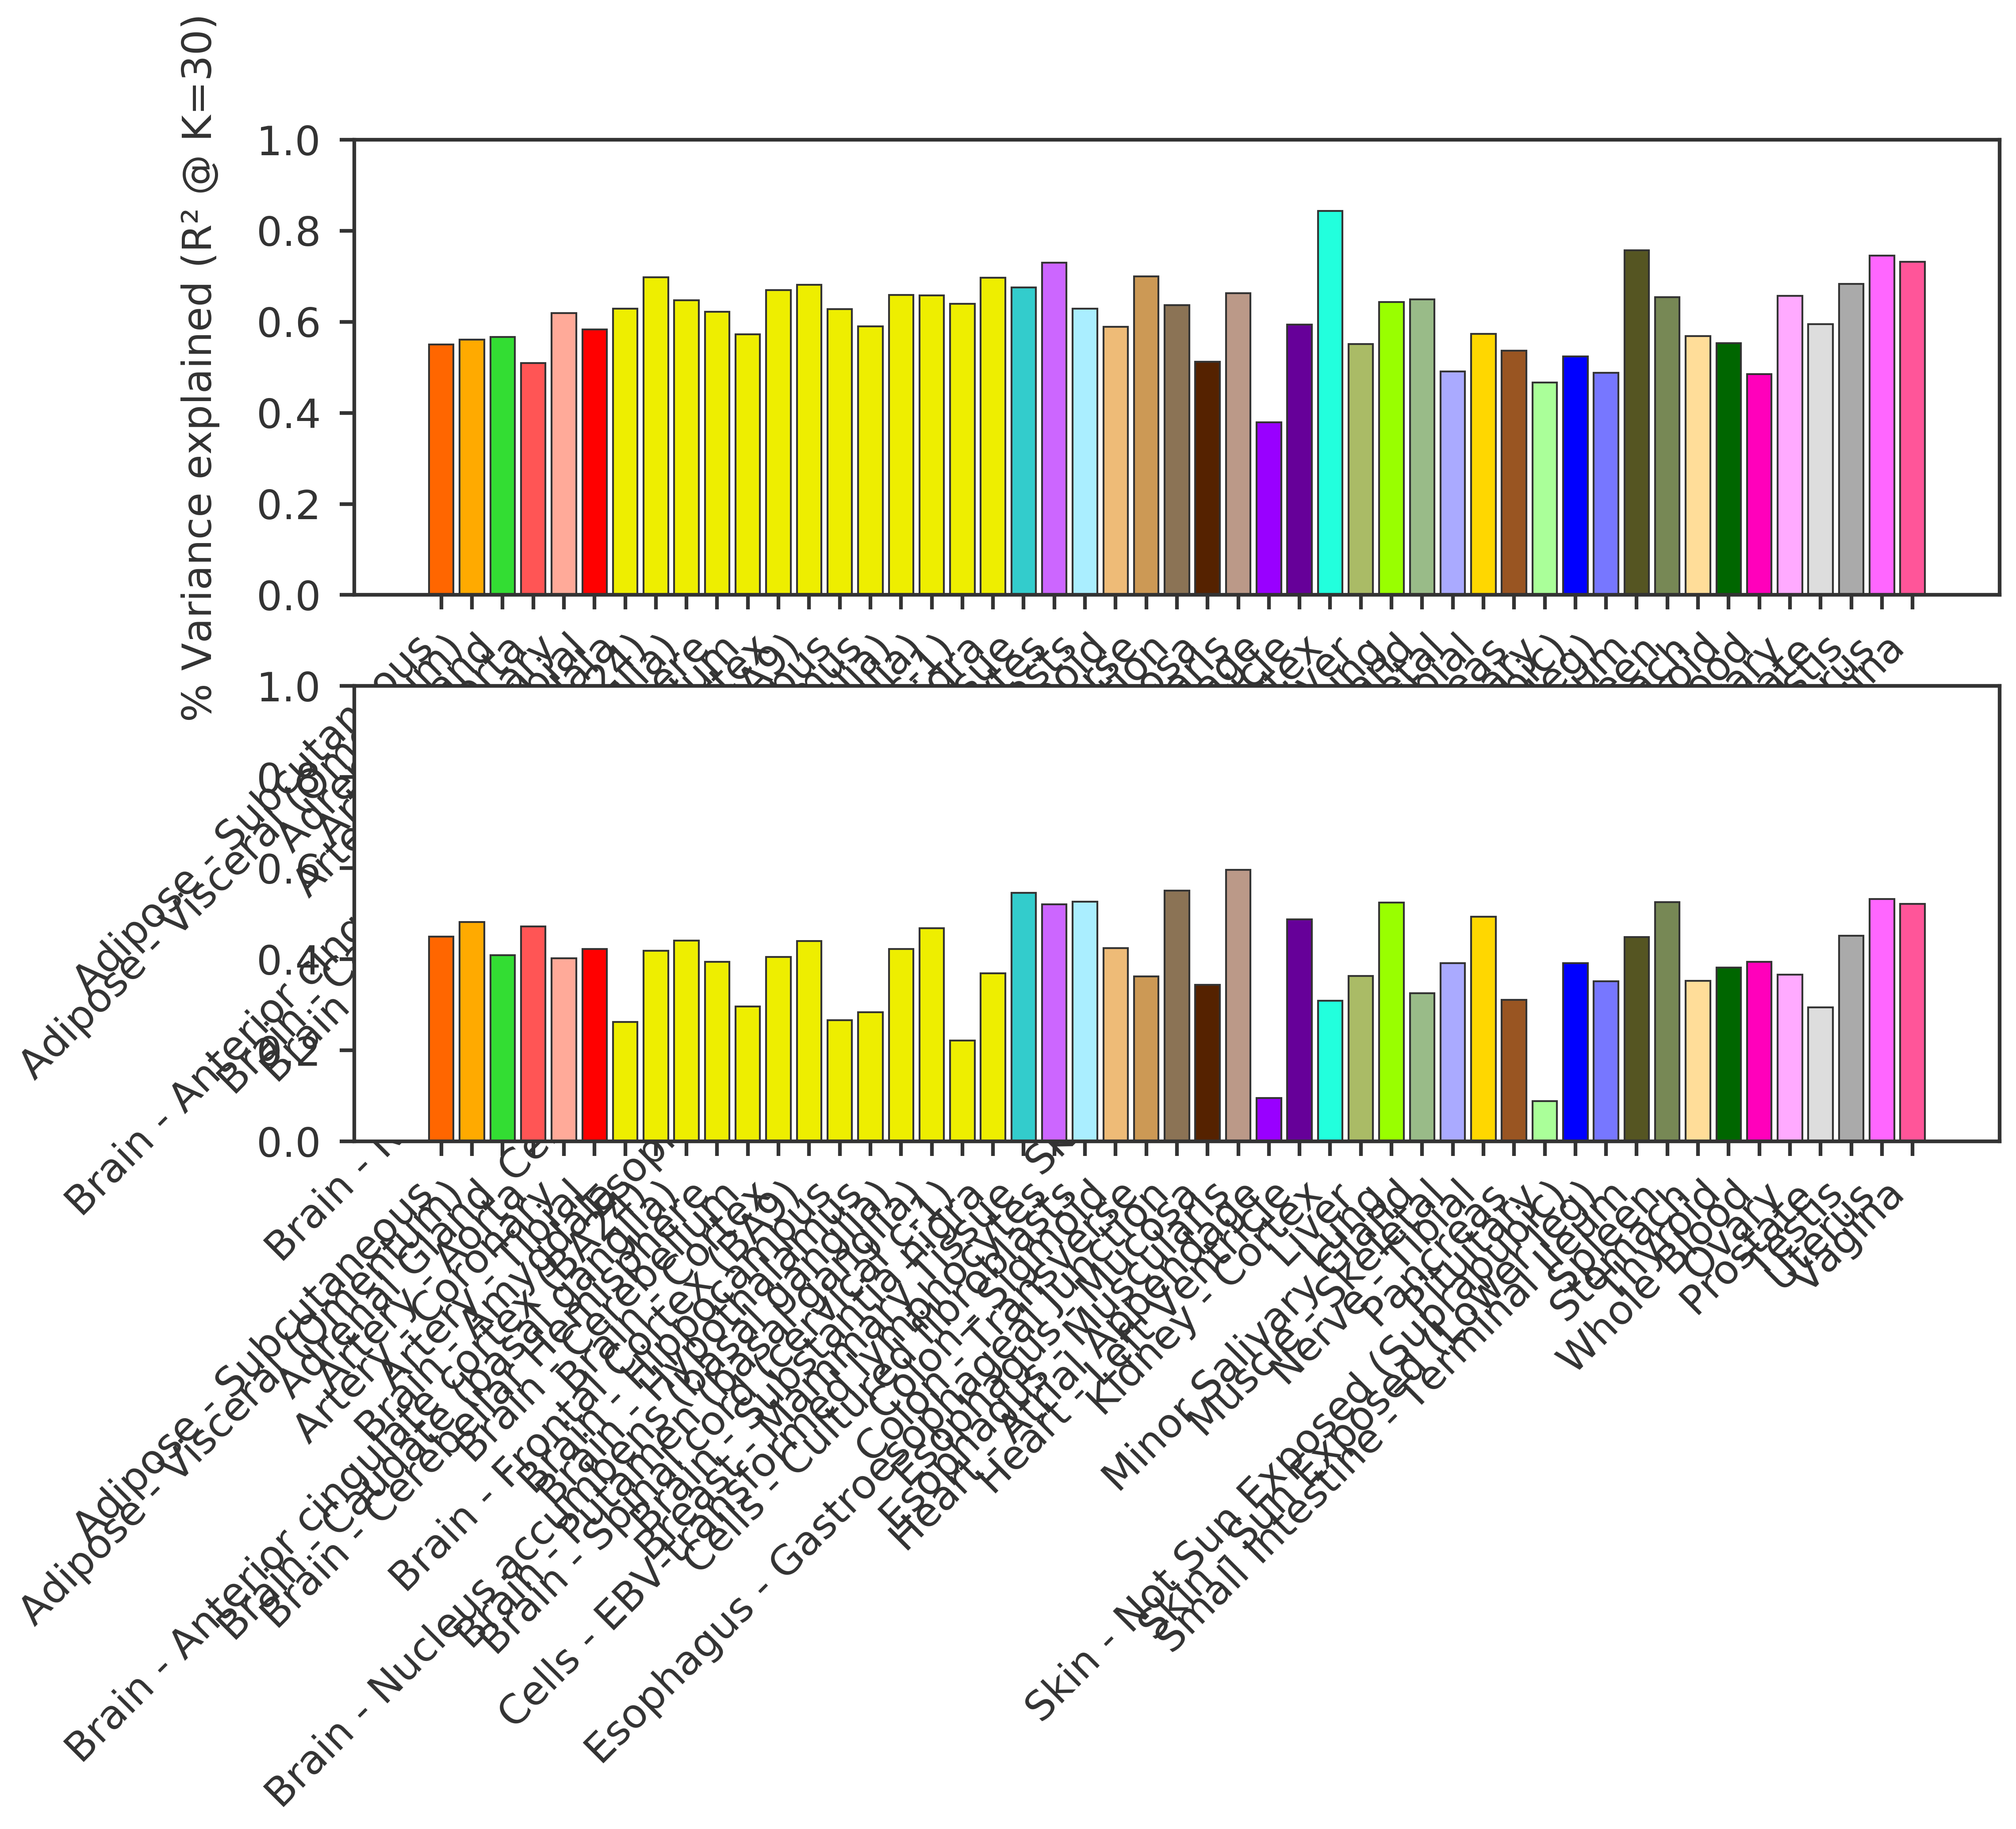

In [12]:
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

fig = plt.figure(figsize=(16,10))
ax1  = fig.add_subplot(211)
ax2  = fig.add_subplot(212)
x = [x[0] for x in multi_r2]
y = [x[1] for x in multi_r2]
ax1.bar(x, y, color=[tissue_colors[i] for i in x])
ax1.set_xticklabels([tissue_names[i] for i in x], rotation=45, ha="right")
ax1.set_ylabel("% Variance explained (R² @ K=30)")
ax1.set_ylim(0,1)

x = [x[0] for x in multi_r2_c]
y = [x[1] for x in multi_r2_c]
ax2.bar(x, y, color=[tissue_colors[i] for i in x])
ax2.set_xticklabels([tissue_names[i] for i in x], rotation=45, ha="right")
# ax2.set_ylabel("% Variance explained (R² @ K=30)")
ax2.set_ylim(0,1)
plt.show()

# What can KNN learn from the public GTEx Covariates?

In [21]:
import json

res_dict = dict()
fs=[0.1,1]

knn_cov_r2 = pd.read_csv("results/multi_r2_ALL_alltissues.txt", header=0, index_col=0, sep="\t")

for f in fs:
    for tissue in tshorts:
        if tissue not in select_tissues:
            continue
        if tissue == "bl":
            continue
        print(tissue)
        gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue)
        rpkm = ReadRPKM(gx_file, "gtex")
        expression = rpkm.expression
        expr_donors = rpkm.donor_ids
        gene_names = rpkm.gene_names

        gx_corr, nb_comp = knn_correction(expression.T, 30, f=f)
        nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)

        # Covariates have size Covariates (rows) x Nsamples (columns)

        # PUBLIC Covariates
        cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
        df_cov_pub = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
        df_cov_pub.drop(["sex", "AGE", "PMI"], inplace=True)

        # SUBJECT covariates
        df_cov = SUBJ_DF.T.copy(deep=True)
        df_cov.columns = df_cov.loc["SUBJID"]
        df_cov.drop(["SUBJID"], inplace=True)

        # SAMPLE covariates
        TISSUE_SAMPLE_DF = SAMPLE_DF[ SAMPLE_DF["SMTSD"] == tissue_names[tissue] ].T.copy(deep=True)
        new_columns = ["-".join(i.split("-")[:2]) for i in TISSUE_SAMPLE_DF.loc["SAMPID"].values]
        TISSUE_SAMPLE_DF.columns = new_columns
        TISSUE_SAMPLE_DF.drop("SAMPID", inplace=True)

        # Concat all covariates and delete those that only have one category
        ALL_COVS = pd.concat([df_cov_pub, df_cov, TISSUE_SAMPLE_DF], join='inner')
        TISSUE_COVS = ALL_COVS.loc[~(ALL_COVS.nunique(axis=1) == 1),:]

        # subset covariates that had r^2 larger than R2_cutoff
        covname_list_c = knn_cov_r2[ knn_cov_r2[tissue] > R2_CUTOFF ].index
        print("Subsetting to {:d} covariates and {:d} samples".format(len(covname_list_c), len(nb_df.columns)))

        # NaNs are taken care in the function, masked out for the scaling
        # Whatever was NaN before, it stays there, and after the scaling, we put it to 0
        sort_cov_df = scale_covariates_nan(TISSUE_COVS.loc[covname_list_c,nb_df.columns]).fillna(0)

        # Multiple Linear regression of all covariates agains KNN component of expression
        r2_list = list()
        xpos = list()
        for K in range(5,100,5):
            print("K ={:>3} - ".format(K), end="")
            gx_corr, nb_comp = knn_correction(expression.T, K, f=f)
            nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
            reg = linear_model.LinearRegression()
            X = sort_cov_df.T ## (12, 581,)
            Y = nb_df.T 
            reg.fit(X, Y)
            r2 = reg.score(X, Y)
            r2_list.append(r2)
            xpos.append(K)
            print("R^2 : {:g}".format(r2))

        for K in range(100,len(expr_donors),50):
            print("K ={:>3} - ".format(K), end="")
            gx_corr, nb_comp = knn_correction(expression.T, K, f=f)
            nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
            reg = linear_model.LinearRegression()
            X = sort_cov_df.T ## (12, 581,)
            Y = nb_df.T 
            reg.fit(X, Y)
            r2 = reg.score(X, Y)
            r2_list.append(r2)
            xpos.append(K)
            print("R^2 : {:g}".format(r2))
        res_dict[tissue] = [xpos,r2_list]
        
    json_dict = json.dumps(res_dict)
    with open("results/KNN_components_f{:g}_alltissues.json".format(f), 'w') as outstream:
        outstream.write(json_dict)

as
Subsetting to 13 covariates and 581 samples
K =  5 - R^2 : 0.253639
K = 10 - R^2 : 0.332418
K = 15 - R^2 : 0.385846
K = 20 - R^2 : 0.40961
K = 25 - R^2 : 0.425947
K = 30 - R^2 : 0.449914
K = 35 - R^2 : 0.464939
K = 40 - R^2 : 0.476042
K = 45 - R^2 : 0.484052
K = 50 - R^2 : 0.492541
K = 55 - R^2 : 0.495389
K = 60 - R^2 : 0.501178
K = 65 - R^2 : 0.506097
K = 70 - R^2 : 0.505481
K = 75 - R^2 : 0.505304
K = 80 - R^2 : 0.505032
K = 85 - R^2 : 0.500822
K = 90 - R^2 : 0.498634
K = 95 - R^2 : 0.494991
K =100 - R^2 : 0.493328
K =150 - R^2 : 0.469736
K =200 - R^2 : 0.437399
K =250 - R^2 : 0.416924
K =300 - R^2 : 0.396094
K =350 - R^2 : 0.375821
K =400 - R^2 : 0.349809
K =450 - R^2 : 0.318111
K =500 - R^2 : 0.248549
K =550 - R^2 : 0.168021
av
Subsetting to 23 covariates and 469 samples
K =  5 - R^2 : 0.330648
K = 10 - R^2 : 0.39851
K = 15 - R^2 : 0.431056
K = 20 - R^2 : 0.455441
K = 25 - R^2 : 0.468413
K = 30 - R^2 : 0.481541
K = 35 - R^2 : 0.495948
K = 40 - R^2 : 0.506159
K = 45 - R^2 : 0.515

K = 80 - R^2 : 0.271066
K = 85 - R^2 : 0.267745
K = 90 - R^2 : 0.257228
K = 95 - R^2 : 0.246549
K =100 - R^2 : 0.240238
K =150 - R^2 : 0.176043
bhy
Subsetting to 6 covariates and 170 samples
K =  5 - R^2 : 0.196763
K = 10 - R^2 : 0.237937
K = 15 - R^2 : 0.258447
K = 20 - R^2 : 0.268209
K = 25 - R^2 : 0.275087
K = 30 - R^2 : 0.283048
K = 35 - R^2 : 0.2858
K = 40 - R^2 : 0.280241
K = 45 - R^2 : 0.286457
K = 50 - R^2 : 0.281774
K = 55 - R^2 : 0.286881
K = 60 - R^2 : 0.284564
K = 65 - R^2 : 0.276682
K = 70 - R^2 : 0.278696
K = 75 - R^2 : 0.283718
K = 80 - R^2 : 0.279709
K = 85 - R^2 : 0.278316
K = 90 - R^2 : 0.277393
K = 95 - R^2 : 0.276489
K =100 - R^2 : 0.264366
K =150 - R^2 : 0.179131
bnu
Subsetting to 11 covariates and 202 samples
K =  5 - R^2 : 0.374385
K = 10 - R^2 : 0.413552
K = 15 - R^2 : 0.434054
K = 20 - R^2 : 0.421547
K = 25 - R^2 : 0.422627
K = 30 - R^2 : 0.42223
K = 35 - R^2 : 0.426827
K = 40 - R^2 : 0.428501
K = 45 - R^2 : 0.433185
K = 50 - R^2 : 0.439028
K = 55 - R^2 : 0.439

K = 35 - R^2 : 0.0921887
K = 40 - R^2 : 0.0879152
K = 45 - R^2 : 0.0876096
K = 50 - R^2 : 0.0820238
K = 55 - R^2 : 0.0814629
K = 60 - R^2 : 0.078362
K = 65 - R^2 : 0.0792132
K = 70 - R^2 : 0.0809171
K = 75 - R^2 : 0.0823997
K = 80 - R^2 : 0.0830165
K = 85 - R^2 : 0.0848148
K = 90 - R^2 : 0.0877613
K = 95 - R^2 : 0.0912558
K =100 - R^2 : 0.0984531
K =150 - R^2 : 0.133064
K =200 - R^2 : 0.247066
K =250 - R^2 : 0.258362
K =300 - R^2 : 0.290949
K =350 - R^2 : 0.181931
hlv
Subsetting to 18 covariates and 386 samples
K =  5 - R^2 : 0.348271
K = 10 - R^2 : 0.405291
K = 15 - R^2 : 0.441896
K = 20 - R^2 : 0.466276
K = 25 - R^2 : 0.478131
K = 30 - R^2 : 0.487557
K = 35 - R^2 : 0.493253
K = 40 - R^2 : 0.495181
K = 45 - R^2 : 0.501431
K = 50 - R^2 : 0.5105
K = 55 - R^2 : 0.517696
K = 60 - R^2 : 0.52198
K = 65 - R^2 : 0.525827
K = 70 - R^2 : 0.523479
K = 75 - R^2 : 0.522325
K = 80 - R^2 : 0.52011
K = 85 - R^2 : 0.520211
K = 90 - R^2 : 0.520755
K = 95 - R^2 : 0.523278
K =100 - R^2 : 0.525693
K =150 

Subsetting to 9 covariates and 227 samples
K =  5 - R^2 : 0.364744
K = 10 - R^2 : 0.41829
K = 15 - R^2 : 0.454831
K = 20 - R^2 : 0.48789
K = 25 - R^2 : 0.499399
K = 30 - R^2 : 0.525544
K = 35 - R^2 : 0.523376
K = 40 - R^2 : 0.503927
K = 45 - R^2 : 0.463446
K = 50 - R^2 : 0.42961
K = 55 - R^2 : 0.41061
K = 60 - R^2 : 0.425678
K = 65 - R^2 : 0.437048
K = 70 - R^2 : 0.455285
K = 75 - R^2 : 0.441205
K = 80 - R^2 : 0.430852
K = 85 - R^2 : 0.412281
K = 90 - R^2 : 0.407003
K = 95 - R^2 : 0.388887
K =100 - R^2 : 0.367171
K =150 - R^2 : 0.330265
K =200 - R^2 : 0.287251
sto
Subsetting to 10 covariates and 324 samples
K =  5 - R^2 : 0.283375
K = 10 - R^2 : 0.341392
K = 15 - R^2 : 0.351827
K = 20 - R^2 : 0.35979
K = 25 - R^2 : 0.359028
K = 30 - R^2 : 0.352611
K = 35 - R^2 : 0.345643
K = 40 - R^2 : 0.349827
K = 45 - R^2 : 0.350613
K = 50 - R^2 : 0.356171
K = 55 - R^2 : 0.363954
K = 60 - R^2 : 0.372179
K = 65 - R^2 : 0.384098
K = 70 - R^2 : 0.403208
K = 75 - R^2 : 0.418559
K = 80 - R^2 : 0.426583
K 

In [56]:
# json_dict = json.dumps(res_dict)
# with open("KNN_components_more_covariates.json", 'w') as outstream:
#     outstream.write(json_dict)

In [1]:
import json
import os 
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

f=1
with open("results/KNN_components_f{:g}_alltissues.json".format(f)) as handle:
    res_dict = json.loads(handle.read())

fig = plt.figure(figsize = (17, 13))
ax1 = fig.add_subplot(211)    
ax2 = fig.add_subplot(212)    
    
for tissue in tshorts:
    if tissue in res_dict:

        if tissue_samples[tissue] < 260:
            X = res_dict[tissue][0]#[:22]
            Y = res_dict[tissue][1]#[:22]
            ax2.plot(X, Y, label=f"{tissue} ({tissue_samples[tissue]})", color=tissue_colors[tissue])
        else:
            X = res_dict[tissue][0]#[:22]
            Y = res_dict[tissue][1]#[:22]
            ax1.plot(X, Y, label=f"{tissue} ({tissue_samples[tissue]})", color=tissue_colors[tissue])

# ax1.set_xlabel("K-nearest Neighbours")
ax1ticks = [10,30,50,70,90,150, 200,250,300,400,500,600]
ax1.set_xticks(ax1ticks)
ax1.set_xticklabels(ax1ticks, rotation=90)
ax1.set_ylabel("Multiple linear regression - $R^2$")
ax2.set_xlabel("K-nearest Neighbours")

ax2ticks = [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200]
ax2.set_xticks(ax2ticks) #,250,300,400,500,600])
ax2.set_xticklabels(ax2ticks, rotation=90)

ax2.set_ylabel("Multiple linear regression - $R^2$")
ax1.legend(bbox_to_anchor=(1.03, 0.15,),borderaxespad=0., loc='lower left', prop={'size': 10}, ncol=3)
ax2.legend(bbox_to_anchor=(1.03, 0.15,),borderaxespad=0., loc='lower left', prop={'size': 10}, ncol=3)
ax1.grid(True, color='gray')
ax2.grid(True, color='gray')
plt.tight_layout()
plt.savefig("results/KNN_Kscan_f{:g}.png".format(f), bbox_inches = 'tight')
plt.show()
        

ModuleNotFoundError: No module named 'utils'

In [13]:
def knn_correction_dev(expr, K, f):
    pca = PCA(n_components= int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    neighbor_list = list()

    neighbour_comp = np.zeros(expr.shape)
    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        neighbour_comp[i,:] = np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        neighbor_list.append(neighbors)

    return gx_knn, neighbour_comp

In [132]:
import collections

def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

res_dict = collections.defaultdict(dict)
for tissue in select_tissues:
    # tissue = "wb"
    print(tissue)
    gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_filtered".format(tissue)
    rpkm = ReadRPKM(gx_file, "gtex")
    expression = rpkm.expression
    expr_donors = rpkm.donor_ids
    gene_names = rpkm.gene_names

    for f in [0.1, 0.2, 0.5, 0.8, 1]:
        print(f)
        gx_corr, nb_comp = knn_correction_dev(expression.T, 30, f)
        nb_df = normalize_expr(pd.DataFrame(nb_comp.T, columns = expr_donors))

        # Covariates have size Covariates (rows) x Nsamples (columns)

        # PUBLIC Covariates
        cov_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
        df_cov_pub = pd.read_csv(cov_file, sep="\t", header=0, index_col=0)
        df_cov_pub.drop(["sex", "AGE", "PMI"], inplace=True)

        # SUBJECT covariates
        df_cov = SUBJ_DF.T.copy(deep=True)
        df_cov.columns = df_cov.loc["SUBJID"]
        df_cov.drop(["SUBJID"], inplace=True)

        # SAMPLE covariates
        TISSUE_SAMPLE_DF = SAMPLE_DF[ SAMPLE_DF["SMTSD"] == tissue_names[tissue] ].T.copy(deep=True)
        new_columns = ["-".join(i.split("-")[:2]) for i in TISSUE_SAMPLE_DF.loc["SAMPID"].values]
        TISSUE_SAMPLE_DF.columns = new_columns
        TISSUE_SAMPLE_DF.drop("SAMPID", inplace=True)

        # Concat all covariates and delete those that only have one category
        ALL_COVS = pd.concat([df_cov_pub, df_cov, TISSUE_SAMPLE_DF], join='inner')
        TISSUE_COVS = ALL_COVS.loc[~(ALL_COVS.nunique(axis=1) == 1),:]

        # # subset covariates that had r^2 larger than R2_cutoff
        # covname_list_c = knn_cov_r2[ knn_cov_r2[tissue] > R2_CUTOFF ].index
        # print("Subsetting to {:d} covariates and {:d} samples".format(len(covname_list_c), len(nb_df.columns)))

        # NaNs are taken care in the function, masked out for the scaling
        sort_cov_df = scale_covariates_nan(TISSUE_COVS.loc[:,nb_df.columns]).fillna(0)

        # Multiple Linear regression of all covariates agains KNN component of expression
        r2_list = list()
        xpos = list()
        for K in range(5,100,5):
            print("K ={:>3} - ".format(K), end="")
            gx_corr, nb_comp = knn_correction_dev(expression.T, K, f)
            nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
            reg = linear_model.LinearRegression()
            X = sort_cov_df.T ## (12, 581,)
            Y = nb_df.T 
            reg.fit(X, Y)
            r2 = reg.score(X, Y)
            r2_list.append(r2)
            xpos.append(K)
            print("R^2 : {:g}".format(r2))

        for K in range(100,min(250, len(expr_donors)),50):
            print("K ={:>3} - ".format(K), end="")
            gx_corr, nb_comp = knn_correction_dev(expression.T, K, f)
            nb_df = pd.DataFrame(nb_comp.T, columns = expr_donors)
            reg = linear_model.LinearRegression()
            X = sort_cov_df.T ## (12, 581,)
            Y = nb_df.T 
            reg.fit(X, Y)
            r2 = reg.score(X, Y)
            r2_list.append(r2)
            xpos.append(K)
            print("R^2 : {:g}".format(r2))
        res_dict[tissue][f] = [xpos,r2_list]

wb
0.1
K =  5 - R^2 : 0.339271
K = 10 - R^2 : 0.409765
K = 15 - R^2 : 0.442547
K = 20 - R^2 : 0.462037
K = 25 - R^2 : 0.475908
K = 30 - R^2 : 0.481517
K = 35 - R^2 : 0.486978
K = 40 - R^2 : 0.491161
K = 45 - R^2 : 0.493473
K = 50 - R^2 : 0.496333
K = 55 - R^2 : 0.498396
K = 60 - R^2 : 0.498657
K = 65 - R^2 : 0.497755
K = 70 - R^2 : 0.498328
K = 75 - R^2 : 0.498223
K = 80 - R^2 : 0.497453
K = 85 - R^2 : 0.497522
K = 90 - R^2 : 0.497609
K = 95 - R^2 : 0.497159
K =100 - R^2 : 0.49761
K =150 - R^2 : 0.49744
K =200 - R^2 : 0.494048
0.2
K =  5 - R^2 : 0.345684
K = 10 - R^2 : 0.417468
K = 15 - R^2 : 0.452566
K = 20 - R^2 : 0.471107
K = 25 - R^2 : 0.483681
K = 30 - R^2 : 0.490466
K = 35 - R^2 : 0.494705
K = 40 - R^2 : 0.497783
K = 45 - R^2 : 0.499597
K = 50 - R^2 : 0.500917
K = 55 - R^2 : 0.50051
K = 60 - R^2 : 0.501186
K = 65 - R^2 : 0.500165
K = 70 - R^2 : 0.499801
K = 75 - R^2 : 0.500026
K = 80 - R^2 : 0.499414
K = 85 - R^2 : 0.498334
K = 90 - R^2 : 0.497347
K = 95 - R^2 : 0.497458
K =100 -

In [133]:
import json
json_dict = json.dumps(res_dict)
# with open("KNN_fraction_of_componentes_in_dist_matrix_r2.json", 'w') as outstream:
#     outstream.write(json_dict)
    
# with open("KNN_fraction_of_componentes_in_dist_matrix_r2_scaled.json", 'w') as outstream:
#     outstream.write(json_dict)

In [136]:
with open("KNN_fraction_of_componentes_in_dist_matrix_r2.json") as infile:
    res_dict_o = json.load(infile)

# with open("KNN_fraction_of_componentes_in_dist_matrix_r2_scaled.json") as infile:
#     res_dict_scaled = json.load(infile)

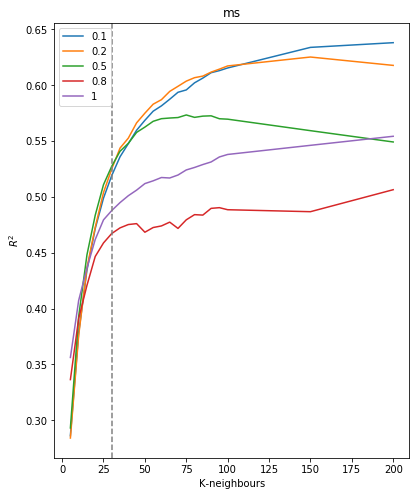

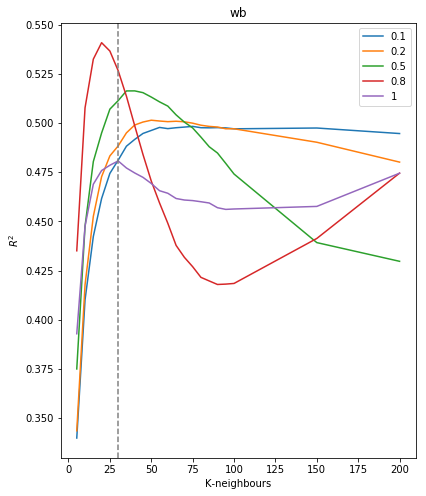

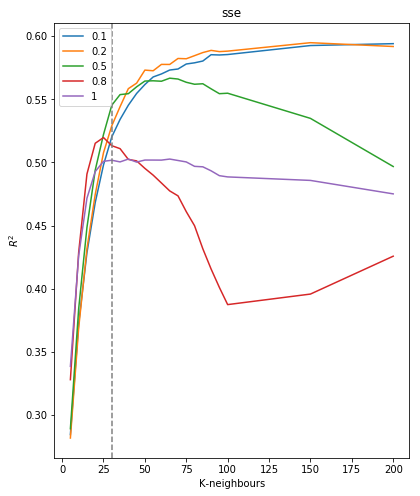

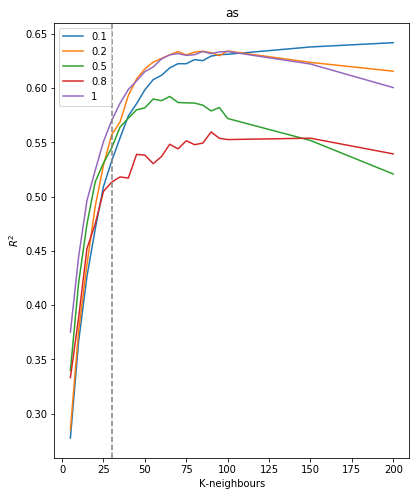

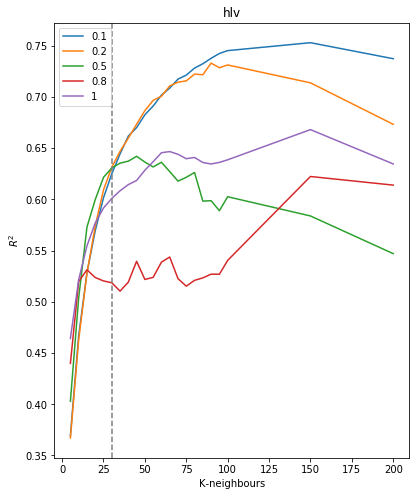

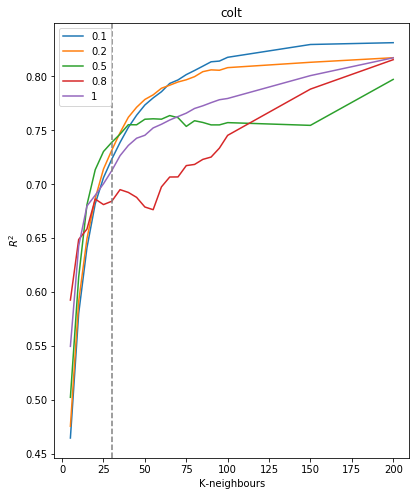

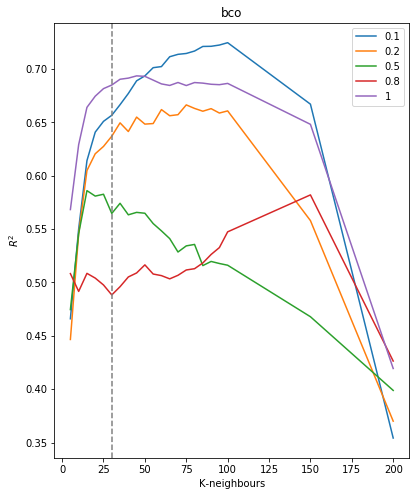

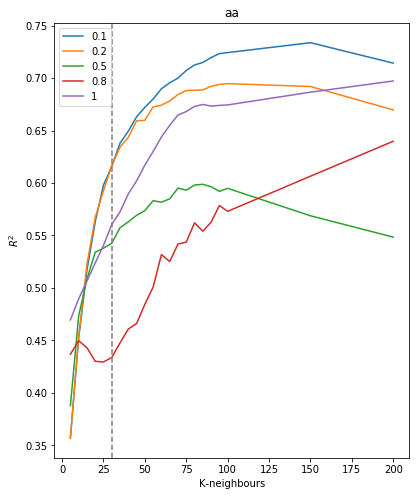

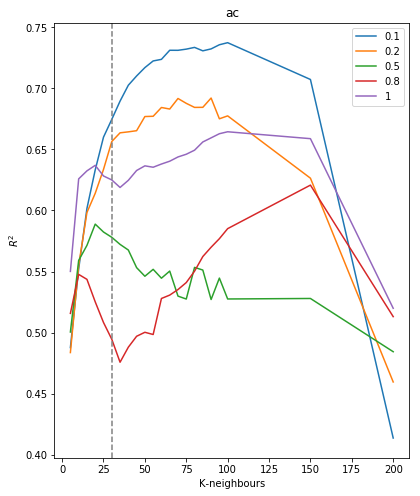

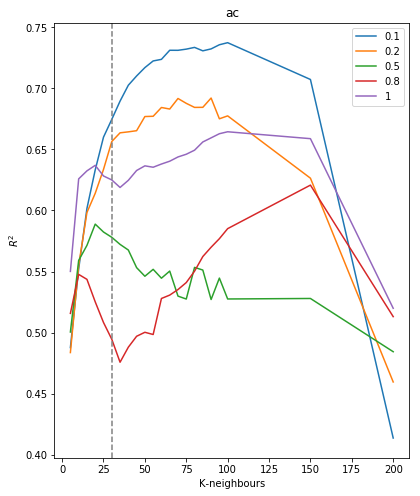

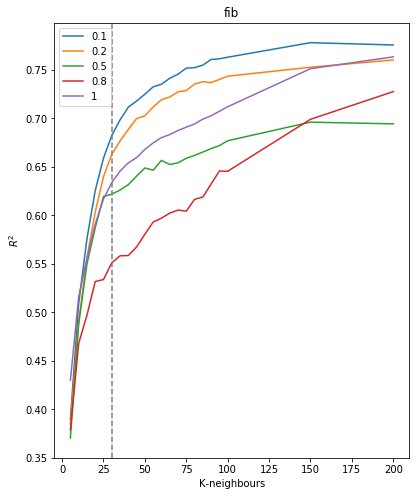

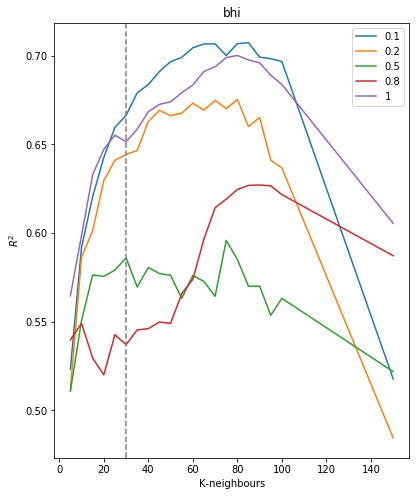

In [146]:

# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, colors = 'banskt', dpi = 90)

for tissue in select_tissues:
    fig = plt.figure(figsize=(14,8))
    ax1  = fig.add_subplot(121)

    for f in [str(x) for x in [0.1, 0.2, 0.5, 0.8, 1]]:
        x, y = res_dict_o[tissue][f]
        ax1.plot(x, y, label=f)
    ax1.set_title(tissue)
    ax1.set_ylabel("$R^2$")
    ax1.set_xlabel("K-neighbours")
    ax1.axvline(30, color="gray", linestyle='--')
    ax1.legend()
    
    plt.savefig("../plots/KNN_PCA_fractions/{:s}.png".format(tissue))
    plt.show()

# The Whole Blood Problem

In [195]:
import re

def normalize_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent


def distmat(expr, K, f):
    pca = PCA(n_components= int(f * min(expr.shape[0], expr.shape[1]) ))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
            
    return distance_matrix

def knn_correction_dev(expr, K, f):
    pca = PCA(n_components= int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    neighbor_list = list()

    neighbour_comp = np.zeros(expr.shape)
    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        neighbour_comp[i,:] = np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        neighbor_list.append(neighbors)

    return gx_knn, neighbour_comp

def read_samples(samplefile):
    if os.path.exists(samplefile):
        with open(samplefile, 'r') as samfile:
            sample = 0
            samplenames = list()
            next(samfile)
            next(samfile)
            for line in samfile:
                if re.search('^#', line):
                    continue
                sample += 1
                samplenames.append(line.strip().split()[0])
    return samplenames

# for tissue in select_tissues:
tissue = "wb"
print(tissue)
gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue)
rpkm = ReadRPKM(gx_file, "gtex")
expression = rpkm.expression
expr_donors = rpkm.donor_ids
gene_names = rpkm.gene_names

# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
# samplenames = read_samples(samplefile)

# common = [x for x in expr_donors if x in samplenames]
# ix = [expr_donors.index(x) for x in common]
# expression_eur = expression[:, ix]

wb


In [225]:
distance_matrix = distmat(expression.T, 30, 0.1)
df = pd.DataFrame(distance_matrix, columns=expr_donors)
mix = np.triu(distance_matrix <= 30, k=1)
plt.imshow(mix)

In [226]:
col_ix = np.sum(mix, axis=0)
collinear_samples_ix = np.where(col_ix > 0)[0]
exclude_samples = [expr_donors[i] for i in collinear_samples_ix]
len(exclude_samples)

327

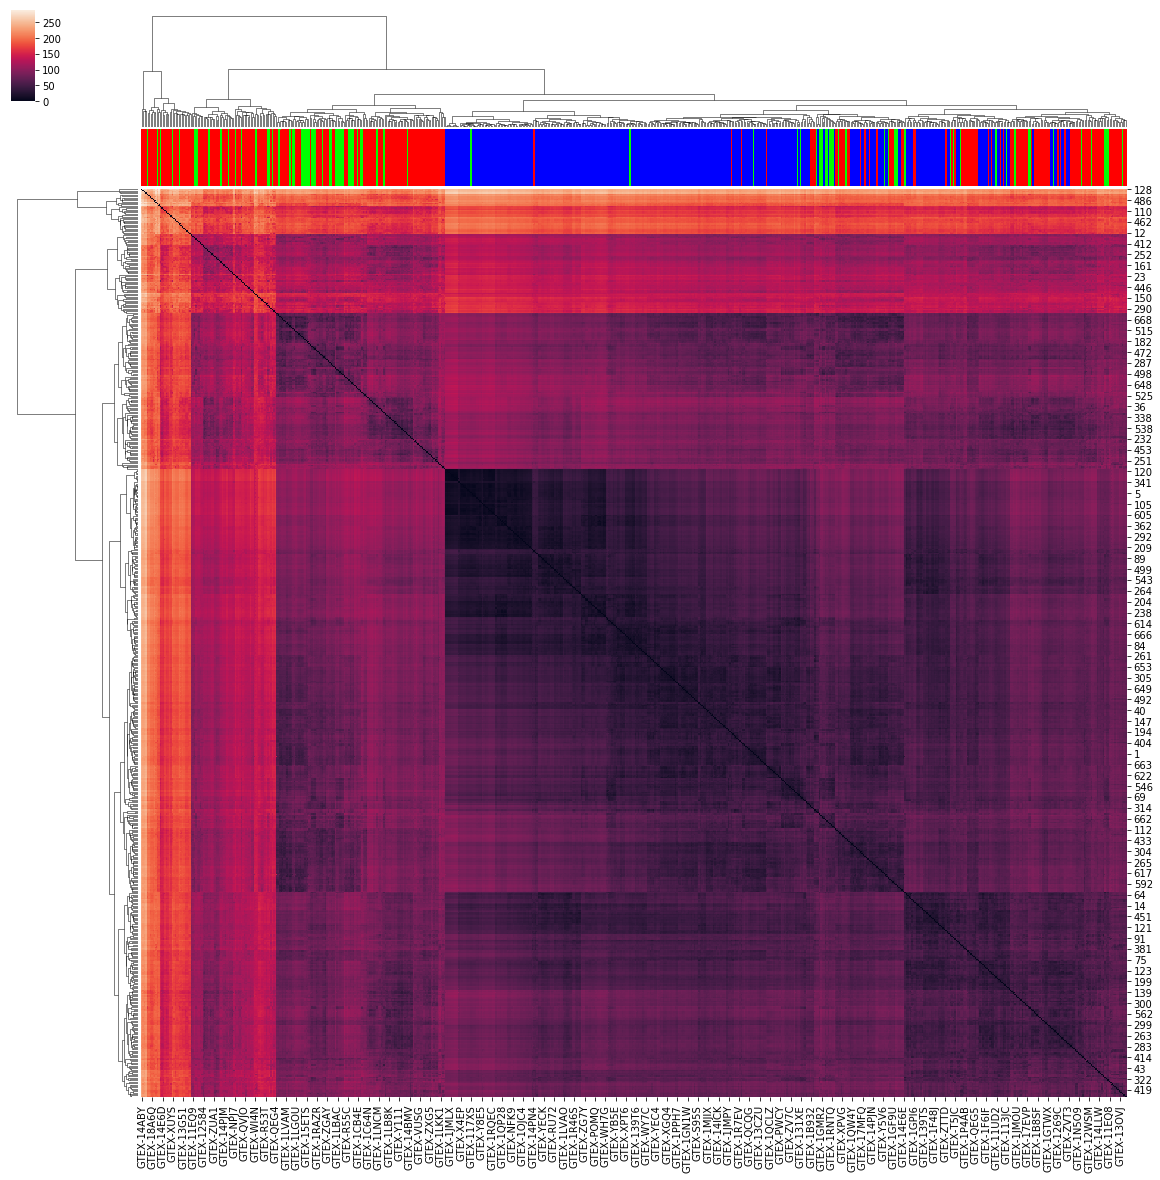

In [216]:
col_colors = list()
for n in expr_donors:
    if n in exclude_samples:
        col_colors.append("#0000ff")
    elif n in samplenames:
        col_colors.append("#ff0000")
    else:
        col_colors.append("#00ff00")
import seaborn as sn
h = sn.clustermap(df, col_colors=col_colors, figsize=(20,20) )       

In [217]:
donor_subset = [x for x in expr_donors if x not in exclude_samples]
subset_ix    = [expr_donors.index(x) for x in donor_subset]
expression_sub = expression[:, subset_ix]



In [218]:
df_sub = pd.DataFrame(expression_sub, columns = donor_subset, index=gene_names)
gx_out_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/{:s}_tpms_qcfilter.collinear_filtered.txt.protein_coding_lncRNA_filtered".format(tissue)
# with open(gx_out_file, 'w') as outf:
#     df_sub.to_csv(outf, header=True, index=True, sep="\t")

In [219]:
df_sub.head()

GTEX-111YS  GTEX-1122O  GTEX-1128S  GTEX-113IC  \
ENSG00000230021.8    -0.044691   -0.124168   -0.112153   -0.028388   
ENSG00000228794.8     0.059766   -0.580565   -0.580565    1.495953   
ENSG00000225880.5     0.204970   -0.503639   -0.503639    1.743607   
ENSG00000188976.10   -0.321969    0.359389    2.552199    0.006300   
ENSG00000187961.13   -0.574232   -0.233863    3.080014   -0.369683   

                    GTEX-113JC  GTEX-117XS  GTEX-117YW  GTEX-1192X  \
ENSG00000230021.8    -0.130072   -0.129259   -0.138081   -0.066005   
ENSG00000228794.8    -0.580565   -0.504158   -0.244078   -0.580565   
ENSG00000225880.5    -0.503639   -0.503639   -0.503639   -0.503639   
ENSG00000188976.10   -0.712317   -0.132866   -0.178751   -0.066754   
ENSG00000187961.13   -0.347577   -0.446189    1.794754    0.541542   

                    GTEX-11DXZ  GTEX-11EI6    ...      GTEX-ZEX8  GTEX-ZF28  \
ENSG00000230021.8    -0.024456   -0.112384    ...      -0.125835  -0.016984   
ENSG00000228794.8     2.243357   -0.580565    ...      -0.580565   1.936565   
ENSG00000225880.5     0.845809   -0.503639    ...      -0.503639   2.390701   
ENSG00000188976.10    0.473526    0.864306    ...       0.399149   2.020928   
ENSG00000187961.13   -0.079283    1.572147    ...      -0.213191   1.447102   

                    GTEX-ZF2S  GTEX-ZF3C  GTEX-ZGAY  GTEX-ZPCL  GTEX-ZUA1  \
ENSG00000230021.8   -0.047814  -0.115915   0.178405  -0.105164  -0.097757   
ENSG00000228794.8   -0.059371   0.067357  -0.066620  -0.580565  -0.580565   
ENSG00000225880.5   -0.161182  -0.503639  -0.053381  -0.503639  -0.503639   
ENSG00000188976.10   1.802985   4.608363  -0.665073  -0.024382   1.791818   
ENSG00000187961.13   1.201251   2.386723  -0.566804  -0.311606   0.322188   

                    GTEX-ZV68  GTEX-ZXES  GTEX-ZXG5  
ENSG00000230021.8   -0.038654  -0.101285  -0.101776  
ENSG00000228794.8    0.149522  -0.580565  -0.344739  
ENSG00000225880.5    1.415210  -0.503639  -0.503639  
ENSG00000188976.10  -0.681342   0.243429  -0.403403  
ENSG00000187961.13  -0.601663  -0.358488   2.325512  

[5 rows x 347 columns]

In [220]:
df_expr = pd.DataFrame(expression, columns = expr_donors, index=gene_names)
df_expr.head()

GTEX-111YS  GTEX-1122O  GTEX-1128S  GTEX-113IC  \
ENSG00000230021.8    -0.044691   -0.124168   -0.112153   -0.028388   
ENSG00000228794.8     0.059766   -0.580565   -0.580565    1.495953   
ENSG00000225880.5     0.204970   -0.503639   -0.503639    1.743607   
ENSG00000188976.10   -0.321969    0.359389    2.552199    0.006300   
ENSG00000187961.13   -0.574232   -0.233863    3.080014   -0.369683   

                    GTEX-113JC  GTEX-117XS  GTEX-117YW  GTEX-1192W  \
ENSG00000230021.8    -0.130072   -0.129259   -0.138081   -0.108890   
ENSG00000228794.8    -0.580565   -0.504158   -0.244078   -0.428872   
ENSG00000225880.5    -0.503639   -0.503639   -0.503639   -0.503639   
ENSG00000188976.10   -0.712317   -0.132866   -0.178751   -0.063908   
ENSG00000187961.13   -0.347577   -0.446189    1.794754   -0.601663   

                    GTEX-1192X  GTEX-11DXX    ...      GTEX-ZV7C  GTEX-ZVE2  \
ENSG00000230021.8    -0.066005   -0.122966    ...      -0.093154  -0.087506   
ENSG00000228794.8    -0.580565   -0.547837    ...      -0.219245  -0.580565   
ENSG00000225880.5    -0.503639   -0.503639    ...      -0.138393  -0.503639   
ENSG00000188976.10   -0.066754   -0.522784    ...       0.061828   0.478378   
ENSG00000187961.13    0.541542   -0.521750    ...      -0.058730  -0.601663   

                    GTEX-ZVP2  GTEX-ZVT2  GTEX-ZVT3  GTEX-ZVT4  GTEX-ZVZP  \
ENSG00000230021.8   -0.074197  -0.040803  -0.130727  -0.138081  -0.113854   
ENSG00000228794.8   -0.373080  -0.208869  -0.580565  -0.544316  -0.440676   
ENSG00000225880.5    0.041683  -0.503639  -0.503639  -0.503639  -0.503639   
ENSG00000188976.10  -0.712317  -0.712317   3.266133  -0.712317  -0.693028   
ENSG00000187961.13  -0.475005  -0.601663   4.064097  -0.572159  -0.601663   

                    GTEX-ZVZQ  GTEX-ZXES  GTEX-ZXG5  
ENSG00000230021.8   -0.104504  -0.101285  -0.101776  
ENSG00000228794.8   -0.580565  -0.580565  -0.344739  
ENSG00000225880.5   -0.503639  -0.503639  -0.503639  
ENSG00000188976.10   0.851540   0.243429  -0.403403  
ENSG00000187961.13  -0.601663  -0.358488   2.325512  

[5 rows x 670 columns]

In [221]:
gx_corr_1, nb_comp_1 = knn_correction_dev(expression.T, 30, 0.1)
gx_corr_2, nb_comp_2 = knn_correction_dev(expression.T, 30, 0.2)
gx_corr_3, nb_comp_3 = knn_correction_dev(expression.T, 30, 1)

gx_corr_1sub, nb_comp_1sub = knn_correction_dev(expression_sub.T, 30, 0.1)
gx_corr_2sub, nb_comp_2sub = knn_correction_dev(expression_sub.T, 30, 0.2)
gx_corr_3sub, nb_comp_3sub = knn_correction_dev(expression_sub.T, 30, 1)

In [228]:
print(expression.shape)
print(a.shape)
print(gx_corr_3.shape)
print(normalize_expr(gx_corr_3.T).shape)

a = normalize_expr(expression)
print("N", np.mean(expression, axis=1).shape)
print(np.mean(expression, axis=1))
print(np.std(expression, axis=1))

print(np.mean(a, axis=1))
print(np.std(a, axis=1))

print(np.mean(gx_corr_3.T, axis=1))
print(np.std(gx_corr_3.T, axis=1))

print(np.mean(normalize_expr(gx_corr_3.T), axis=1))
print(np.std(normalize_expr(gx_corr_3.T), axis=1))


(12046, 670)
(12046, 670)
(670, 12046)
(12046, 670)
N (12046,)
[ 1.32563943e-18 -1.59076732e-17 -5.30255773e-18 ...  3.97691830e-18
 -3.44666252e-17  1.85589521e-17]
[1. 1. 1. ... 1. 1. 1.]
[ 1.32563943e-18 -5.30255773e-18 -5.30255773e-18 ... -1.59076732e-17
 -1.32563943e-17  7.95383659e-18]
[1. 1. 1. ... 1. 1. 1.]
[0.09756153 0.30602674 0.25649821 ... 0.35771126 0.59311813 0.4486224 ]
[1.00113392 0.92405362 0.94323165 ... 0.95909234 0.93765952 0.89299521]
[ 0.00000000e+00  3.44666252e-17 -5.30255773e-18 ...  2.51871492e-17
  8.88178420e-17 -1.59076732e-17]
[1. 1. 1. ... 1. 1. 1.]


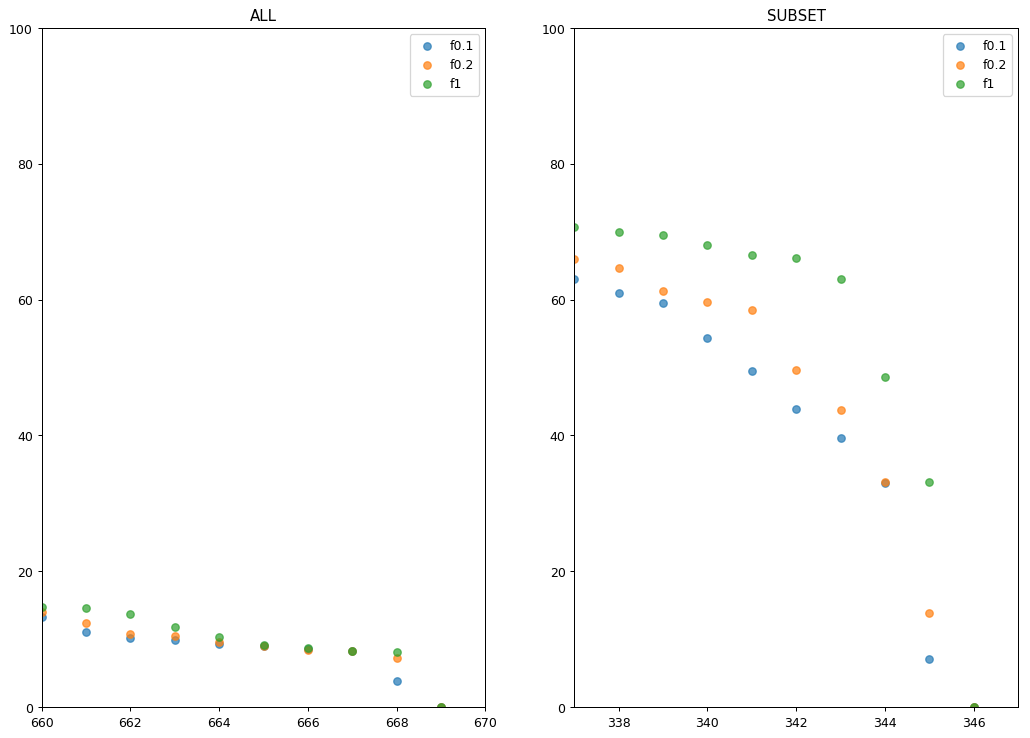

In [222]:
u1, ns1, v1 = np.linalg.svd(normalize_expr(gx_corr_1.T))
u2, ns2, v2 = np.linalg.svd(normalize_expr(gx_corr_2.T))
u3, ns3, v3 = np.linalg.svd(normalize_expr(gx_corr_3.T))

u1, s1, v1 = np.linalg.svd(normalize_expr(gx_corr_1sub.T))
u2, s2, v2 = np.linalg.svd(normalize_expr(gx_corr_2sub.T))
u3, s3, v3 = np.linalg.svd(normalize_expr(gx_corr_3sub.T))

fig = plt.figure(figsize=(14,10), dpi=90)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(np.arange(len(ns1)), ns1, label="f0.1", alpha=0.7)
ax1.scatter(np.arange(len(ns2)), ns2, label="f0.2", alpha=0.7)
ax1.scatter(np.arange(len(ns3)), ns3, label="f1", alpha=0.7)
ax1.set_xlim(len(ns1)-10,len(ns1))
ax1.set_ylim(0,100)
ax1.set_title("ALL")

ax2.scatter(np.arange(len(s1)), s1, label="f0.1", alpha=0.7)
ax2.scatter(np.arange(len(s2)), s2, label="f0.2", alpha=0.7)
ax2.scatter(np.arange(len(s3)), s3, label="f1", alpha=0.7)
ax2.set_xlim(len(s1)-10,len(s1))
ax2.set_ylim(0,100)
ax2.set_title("SUBSET")

ax1.legend()
ax2.legend()

plt.show()

In [234]:
# for tissue in select_tissues:
tissue = "wb"
print(tissue)
gx_file = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue)
rpkm = ReadRPKM(gx_file, "gtex")
expression = rpkm.expression
expr_donors = rpkm.donor_ids
gene_names = rpkm.gene_names

gx_0 = normalize_expr(expression)
gx_corr_1 = normalize_expr(knn_correction_dev(expression.T, 30, 1)[0].T)
gx_corr_2 = normalize_expr(knn_correction_dev(expression.T, 45, 1)[0].T)
gx_corr_3 = normalize_expr(knn_correction_dev(expression.T, 60, 1)[0].T)

u0, s0, v0 = np.linalg.svd(gx_0.T)
u1, s1, v1 = np.linalg.svd(gx_corr_1.T)
u2, s2, v2 = np.linalg.svd(gx_corr_2.T)
u3, s3, v3 = np.linalg.svd(gx_corr_3.T)

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.scatter(np.arange(len(s0)-1), s0[:-1], label="0" , alpha=0.4 )
ax.scatter(np.arange(len(s1)-1), s1[:-1], label="30" , alpha=0.4 )
ax.scatter(np.arange(len(s2)-1), s2[:-1], label="45" , alpha=0.4 )
ax.scatter(np.arange(len(s3)-1), s3[:-1], label="60" , alpha=0.4 )
ax.legend()
plt.show()

wb


670